In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np
import sklearn

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline


import re

In [2]:
hotels_df = pd.read_csv('data_hotels.csv')
# hotels_df

# Khám phá dữ liệu

In [3]:
# hotels_df=pd.read_csv('data_hotels.csv',index_col=0)
hotels_df

,Name,District,Star,RatingScore,Num_ratings,Price(VND),Pool,Parking,Restaurant
0,Angel Hotel Danang,Sơn Trà,3.0,8.6,287,162790,No,Yes,Yes
1,Stella Maris Beach Danang,Sơn Trà,4.0,8.9,63,832500,No,Yes,Yes
2,Khách sạn DLG Đà Nẵng,Sơn Trà,4.5,9.3,62,1026908,No,Yes,Yes
3,San Marino Boutique Danang,Sơn Trà,4.0,9.0,212,600000,No,Yes,Yes
4,Khách sạn Raon Danang Beach,Ngũ Hành Sơn,3.0,8.8,613,337920,No,No,Yes
...,...,...,...,...,...,...,...,...,...
484,Nhat Minh Hotel and Apartment,Ngũ Hành Sơn,3.5,8.2,26,678805,No,Yes,Yes
485,Khách sạn Danang Riverside,Sơn Trà,4.0,8.4,82,1760000,No,Yes,Yes
486,Khách sạn Night Sky,Quận Hải Châu,2.0,8.8,111,414000,No,Yes,Yes
487,Ngoi Nha Xanh Hotel,Quận Hải Châu,2.0,7.4,146,240000,No,Yes,Yes


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [5]:
hotels_df.shape

(489, 9)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

### Dữ liệu có các dòng bị lặp không?

In [6]:
hotels_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

In [4]:
# xem file mô tả
with open('description.txt', 'r',encoding='utf-8') as f:
    print(f.read())

DỮ LIỆU THÔNG TIN CƠ BẢN CỦA KHÁCH SẢN 

VARIABLE DESCRIPTIONS:

Name			Tên khách sạn

District		Quận; huyện của khách sạn
	
Star			Số sao của khách sạn

RatingScore		Điểm đánh giá khách sạn
	
Num_ratings		Số người đánh giá khách sạn

Price(VND)		Giá thuê phòng (1 đêm/2 người) của khách sạn
	
Pool			Hồ bơi 
			(Yes; No)
Parking			Chỗ đậu xe
			(Yes; No)
Restaurant		Nhà hàng
			(Yes; No)





In [8]:
# kiểu dữ liệu của mỗi cột
dtypes=hotels_df.dtypes
dtypes

Name            object
District        object
Star           float64
RatingScore    float64
Num_ratings      int64
Price(VND)       int64
Pool            object
Parking         object
Restaurant      object
dtype: object

## Câu hỏi:

*Output - Price(VND) -* được tính từ *input - các thông tin của khách sạn -* theo công thức nào?
Ý nghĩa: Dự đoán giá phòng khách sạn từ các thông tin cơ bản.

In [9]:
# Cột output hiện có kiểu dữ liệu gì?
hotels_df['Price(VND)'].dtype

dtype('int64')

## Đổi đơn vị cột Price(VND) --> triệu đồng


In [10]:
hotels_df['Price(VND)'].describe()

def fix(s):
    return np.round(s/1000000,3)
# df['Price(VND)']=df['Price(VND)'].astype(np.float64)
hotels_df['Price(VND)'] = hotels_df['Price(VND)'].apply(fix)

## Tiền xử lý (tách các tập)

In [11]:
# Tách X và y
y = hotels_df["Price(VND)"] 
X = hotels_df.drop("Price(VND)", axis=1)

In [12]:
# Tách tập huấn luyện và tập train theo tỉ lệ 80%:20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
# Tách tập huấn luyện và tập validation theo tỉ lệ 80%:20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [13]:
X_train.shape

(312, 8)

In [14]:
y_train.shape

(312,)

In [15]:
X_val.shape

(79, 8)

In [16]:
y_val.shape

(79,)

In [17]:
X_train.head().index

Int64Index([316, 227, 16, 44, 74], dtype='int64')

**Kiểu dữ liệu của các cột Input**

In [18]:
X_train.dtypes

Name            object
District        object
Star           float64
RatingScore    float64
Num_ratings      int64
Pool            object
Parking         object
Restaurant      object
dtype: object

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

Trong `X_train`, có 3/8 cột có dtype không phải là object:

In [19]:
X_train.dtypes[X_train.dtypes != object]

Star           float64
RatingScore    float64
Num_ratings      int64
dtype: object

In [20]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)

`'Star', 'RatingScore', 'Num_ratings'` không bị thiếu dữ liệu

In [21]:
num_cols = ['Star', 'RatingScore', 'Num_ratings']
df = X_train[num_cols]
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Star,RatingScore,Num_ratings
missing_ratio,0.0,0.0,0.0
min,0.0,0.0,0.0
lower_quartile,2.0,0.0,0.0
median,2.5,8.3,19.0
upper_quartile,3.0,8.7,68.0
max,5.0,9.7,1032.0


### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [22]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(X_train.columns) - set(num_cols))
df = X_train[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,Name,Restaurant,District,Pool,Parking
missing_ratio,0,0,0,0,0
num_values,312,2,7,2,2
value_ratios,"{'Jolia Hotel and Apartment': 0.3, 'Avalon Hotel': 0.3, 'An Nam Hotel': 0.3, 'Bay Sydney Hotel': 0.3, 'Bright Hotel': 0.3, 'Khách sạn căn hộ Raon': 0.3, 'Haian Riverfront Hotel Da Nang.': 0.3, 'Tr...","{'Yes': 65.1, 'No': 34.9}","{'Sơn Trà': 42.3, 'Ngũ Hành Sơn': 28.5, 'Quận Hải Châu': 21.5, 'Thanh Khê': 4.2, 'Đà Nẵng': 1.9, 'Quận Cẩm Lệ': 1.0, 'Liên Chiểu': 0.6}","{'No': 84.3, 'Yes': 15.7}","{'Yes': 53.2, 'No': 46.8}"


## Tiền xử lý (tập huấn luyện) 

* Đầu tiên, ta sẽ bỏ cột "Name" đi.
* Chuyển Price(VND) đơn vị đông --> Price(VND) --> đơn vị triệu đồng // bước này chưa làm

In [23]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        dropped_cols=["Name"]
        df = X_df.copy()
        df.drop(dropped_cols, axis=1, inplace=True)
        return df

In [24]:
#test
col_adderdropper = ColDropper()
col_adderdropper.fit(X_train)
fewer_cols_train_X_df = col_adderdropper.transform(X_train)
fewer_cols_train_X_df.head()

,District,Star,RatingScore,Num_ratings,Pool,Parking,Restaurant
316,Quận Hải Châu,1.0,0.0,0,No,Yes,No
227,Liên Chiểu,0.0,0.0,0,No,No,No
16,Sơn Trà,3.0,8.7,221,No,Yes,Yes
44,Đà Nẵng,4.0,8.7,301,No,Yes,Yes
74,Sơn Trà,2.0,8.1,141,No,No,Yes


In [25]:
nume_cols = ['Star', 'RatingScore', 'Num_ratings']

cate_cols=['District','Pool','Parking','Restaurant']
imp_mode = SimpleImputer(strategy='most_frequent')
onehot=OneHotEncoder(handle_unknown='ignore',sparse=False)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nume_cols),
        ('cat', categorical_transformer, cate_cols)])

preprocess_pipeline = Pipeline(steps=[
    ('coldropper', ColDropper()),
    ('preprocess', preprocessor),
    ('scaler', StandardScaler())])

preprocessed_train_X = preprocess_pipeline.fit_transform(X_train)
preprocessed_train_X.shape


(312, 16)

## Tiền xử lý (tập validation)

In [26]:
preprocessed_val_X=preprocess_pipeline.transform(X_val)

In [27]:
mlpregressor = MLPRegressor(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500)
mlpclassifier = MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500)

logisticregression=LogisticRegression(multi_class="multinomial", solver="lbfgs",max_iter=1000)
colNormalize = StandardScaler()
col_adderdropper =ColDropper()

full_pipeline = make_pipeline(col_adderdropper, preprocessor, colNormalize, mlpregressor)
# full_pipeline = make_pipeline(col_adderdropper, preprocessor, colNormalize, mlpclassifier)
# raise NotImplementedError()

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
best_val_err = float('inf'); best_alpha = None; best_num_top_titles = None
for alpha in alphas:
    full_pipeline.set_params(mlpregressor__alpha=alpha)
#     full_pipeline.set_params(mlpclassifier__alpha=alpha)
    full_pipeline.fit(X_train, y_train);
#         pred_y = full_pipeline.predict(val_X_df)
    train_score = full_pipeline.score(X_train, y_train)
    val_score = full_pipeline.score(X_val, y_val)
    train_errs.append((1-train_score)*100)
    val_errs.append((1-val_score)*100)
best_val_err=min(val_errs)
index_=val_errs.index(best_val_err)
# best_num_top_titles=num_top_titles_s[index_%6]
best_alpha=alphas[index_]
val_errs

[221.28807272049804,
 111.57217787493951,
 93.02184956574237,
 96.32250177427244,
 100.00061061513685]

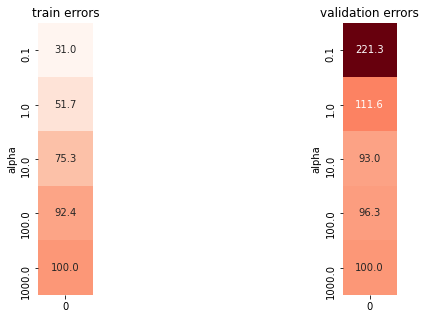

In [28]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.ylabel('alpha');

In [29]:
full_pipeline.set_params(mlpregressor__alpha=best_alpha)
full_pipeline.fit(X, y)

pred_y = full_pipeline.predict(X_test)
df = pd.DataFrame()
df['STT']=X_test.index
df['Price(VND)']=pred_y
# df=df.set_index('PassengerId')
# df.to_csv('my_preds.csv', encoding='utf-8', sep=',', index='PassengerId')
df

,STT,Price(VND)
0,457,0.919144
1,107,1.249694
2,165,0.425803
3,197,0.585148
4,446,0.572352
...,...,...
93,92,0.619096
94,385,1.045192
95,119,0.368199
96,261,0.748279


In [30]:
hotels_df['Price(VND)'].describe()

count    489.000000
mean       0.749566
std        0.938993
min        0.138000
25%        0.349000
50%        0.504000
75%        0.799000
max       10.351000
Name: Price(VND), dtype: float64

## Đánh giá mô hình

In [31]:
full_pipeline.score(X_test,y_test)

0.5803173723062386